# Análise de Corvengência de Municípios
## Daniel N. Rocha, Rafael Kovashikawa, Matheus Roman e Chen Zi
### Trabalho de Estatística – FGV EPGE
O objetivo deste estudo é realizar testes estatísticos com dados empíricos do IBGE para testar a hipótese de corvergência acerca da evolução do PIB dos municípios brasileiros. Isto é, testaremos se os municípios com economia menor de fato cresceram mais rapidamente do que os que possuiam atividade econômica mais intensa.

Embora haja disponibilidade de dados a partir 1999, utilizamos o ano de 2002 como período inicial, tendo em vista que houve mudança metodológica na coleta e agregação dos dados entre os anos de 1999 e 2002. Segundo o IBGE: 

"_Para os anos anteriores a 2010, cabe ressaltar, realizou-se a retropolação dos dados até 2002, considerando-se a disponibilidade de informações para o período, e estimou-se uma nova série, adaptada às alterações da CNAE 2.0. [Classificação Nacional de Atividades Econômicas - CNAE 2.0.]_"

A série temporal termina em 2017 pois é o último ano de dados disponibilizados pelo IBGE. Dentro do recorte temporal selecionado é possível garantir que os dados são comparáveis entre si e "estão completamente integrados às séries das Contas Nacionais e das Contas Regionais do Brasil".

In [1]:
%%capture
%pip install xlrd
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install palettable
%pip install matplotlib
%pip install jupyterthemes

In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import seaborn as sns
import palettable
import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-yatflcf_ because the default path (/config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import matplotlib.style
import matplotlib as mpl
mpl.rcParams['grid.color'] = 'white'
# mpl.rcParams['legend.labelcolor'] = 'white'
mpl.rcParams['axes.titlecolor'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
mpl.rcParams['axes.titlesize'] = '20.0'
mpl.rcParams['figure.figsize'] = '13.0, 8.0'
mpl.rcParams['legend.framealpha'] = '0.8'

## 1. Importando os Dados:
Todos os dados foram coletados do site do IBGE e podem ser consultados no seguinte link: https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html

In [4]:
pib_cities_02_09 = pd.read_excel('PIB dos Munic¡pios - base de dados 2002-2009.xls')
pib_cities_10_17 = pd.read_excel('PIB dos Munic¡pios - base de dados 2010-2017.xls')

In [5]:
pib_cities = pd.concat([pib_cities_02_09, pib_cities_10_17], ignore_index=True)
pib_cities = pib_cities.copy()

In [10]:
pib_cities = pib_cities[['Ano','Nome da Grande Região','Nome da Unidade da Federação','Nome do Município',
                         'Código do Município','Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)',
                         'Valor adicionado bruto total, \na preços correntes\n(R$ 1.000)',
                         'Produto Interno Bruto, \na preços correntes\n(R$ 1.000)']]
pib_cities.rename(inplace=True, columns={'Produto Interno Bruto, \na preços correntes\n(R$ 1.000)':'PIB',
                              'Valor adicionado bruto total, \na preços correntes\n(R$ 1.000)':'Valor adicionado',
                              'Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)':'PIB per capta',
                              'Nome da Grande Região':'Região','Nome da Unidade da Federação':'UF',
                              'Nome do Município':'Município'})
pib_cities.sort_values(['Município','Ano'],inplace=True,ignore_index=True)
pib_cities['População'] = pib_cities['PIB']/pib_cities['PIB per capta']

### Criando colunas de variação percentual

In [7]:
pib_cities['Região']
for i in ['PIB per capta','Valor adicionado','PIB','População']:
    pib_cities['PC_'+i.split(' ')[-1]] = pib_cities.groupby('Município')[i].apply(pd.Series.pct_change)

## 2. Séries Incompletas:
Algumas cidades foram criadas após 2002 e, portanto, não possues valores para todos os anos de comparação. Buscaremos eliminar essas cidades da base de dados

In [37]:
pib_cities['Código do Município'].value_counts().value_counts()

16    5560
5        5
13       4
9        1
Name: Código do Município, dtype: int64

In [38]:
pib_cities['Código do Município'].nunique()

5570

In [39]:
codigo = pib_cities['Código do Município'].value_counts()[pib_cities['Código do Município'].value_counts()!=16].index
codigo

Int64Index([5003900, 5104542, 5104526, 2200954, 2206720, 1504752, 4220000,
            5006275, 4314548, 4212650],
           dtype='int64')

In [40]:
pib_cities = pib_cities[~pib_cities['Código do Município'].isin(codigo)]
pib_cities

,Ano,Região,UF,Município,Código do Município,PIB per capta,Valor adicionado,PIB,População,PC_capta,PC_adicionado,PC_PIB,PC_População
0,2002,Centro-oeste,Goiás,Abadia de Goiás,5200050,3552.65,18196.128,19813.138,5.577003,NaN,NaN,NaN,NaN
1,2003,Centro-oeste,Goiás,Abadia de Goiás,5200050,3915.65,21263.259,22773.416,5.815999,0.102177,0.168560,0.149410,0.042854
2,2004,Centro-oeste,Goiás,Abadia de Goiás,5200050,3924.03,22441.792,23756.057,6.053995,0.002140,0.055426,0.043149,0.040921
3,2005,Centro-oeste,Goiás,Abadia de Goiás,5200050,4473.47,26567.432,28156.001,6.293996,0.140019,0.183837,0.185214,0.039643
4,2006,Centro-oeste,Goiás,Abadia de Goiás,5200050,4771.80,29378.047,31164.647,6.531004,0.066689,0.105792,0.106856,0.037656
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89041,2013,Sudeste,São Paulo,Óleo,3533809,22610.72,60428.099,60506.294,2.676000,0.515231,0.540607,0.544671,0.019429
89042,2014,Sudeste,São Paulo,Óleo,3533809,29120.06,77075.864,77226.408,2.652000,0.287887,0.275497,0.276337,-0.008969
89043,2015,Sudeste,São Paulo,Óleo,3533809,31658.75,82658.788,83199.184,2.628000,0.087180,0.072434,0.077341,-0.009050
89044,2016,Sudeste,São Paulo,Óleo,3533809,34502.38,89060.644,89878.689,2.605000,0.089821,0.077449,0.080283,-0.008752


In [41]:
pib_cities['Código do Município'].value_counts().value_counts()

16    5560
Name: Código do Município, dtype: int64

## 3. Plotando os Retornos:

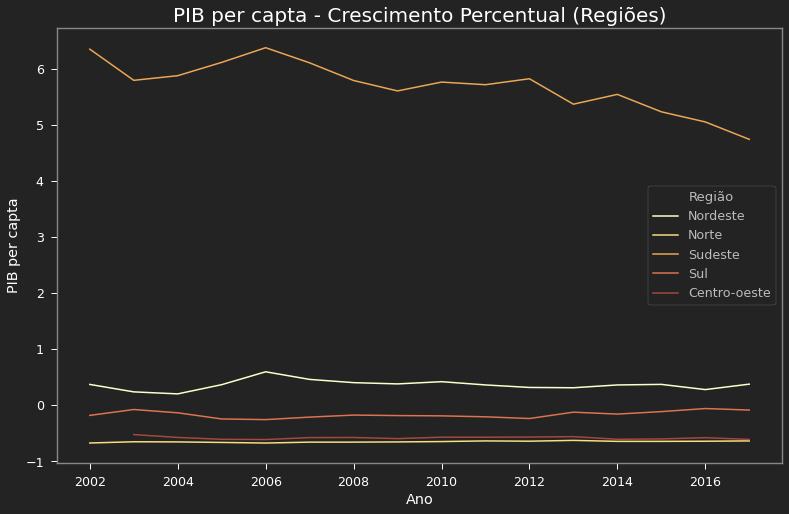

In [106]:
cmap = palettable.scientific.sequential.LaJolla_7.hex_colors[:-2]
agg=pib_cities.groupby(['Ano','Região']).sum()[['PIB per capta','Valor adicionado','PIB','População']].reset_index()
data=agg[['PIB per capta','Valor adicionado','PIB','População']].pct_change().dropna()
data.insert(0,'Ano',agg['Ano'])
data.insert(1,'Região',agg['Região'])
sns.lineplot(data=data,x='Ano',y='PIB per capta',hue='Região',palette=cmap)
plt.title('PIB per capta - Crescimento Percentual (Regiões)');

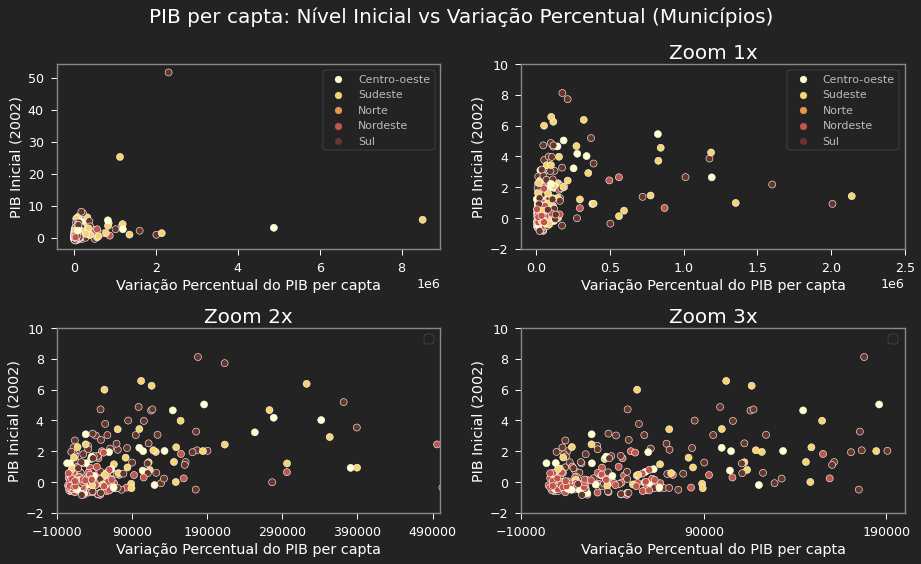

In [102]:
c = palettable.scientific.sequential.LaJolla_6.hex_colors[:-1]
for k,v in {0:[1,1,1,1],1:[-2,10,-100000,2500000],2:[-2,10,-10000,500000],3:[-2,10,-10000,200000]}.items():
    plt.subplot(2,2,k+1)
    sns.scatterplot(data=pib_cities,y='PC_capta',x=pib_cities[pib_cities['Ano']==2002]['PIB'],hue='Região',palette=c)
    plt.ylabel('PIB Inicial (2002)')
    plt.xlabel('Variação Percentual do PIB per capta')
    if k>0:
        plt.title('Zoom '+str(k)+'x')
        plt.ylim(v[0],v[1])
        plt.xlim(v[2],v[3]);
        plt.legend('')
    if k>1:
        plt.xticks(np.arange(v[2], v[3]+1, 100000))
    else:
        plt.legend(fontsize='small',loc='upper right')
plt.suptitle('PIB per capta: Nível Inicial vs Variação Percentual (Municípios)', color='w', fontsize=20)
plt.tight_layout();

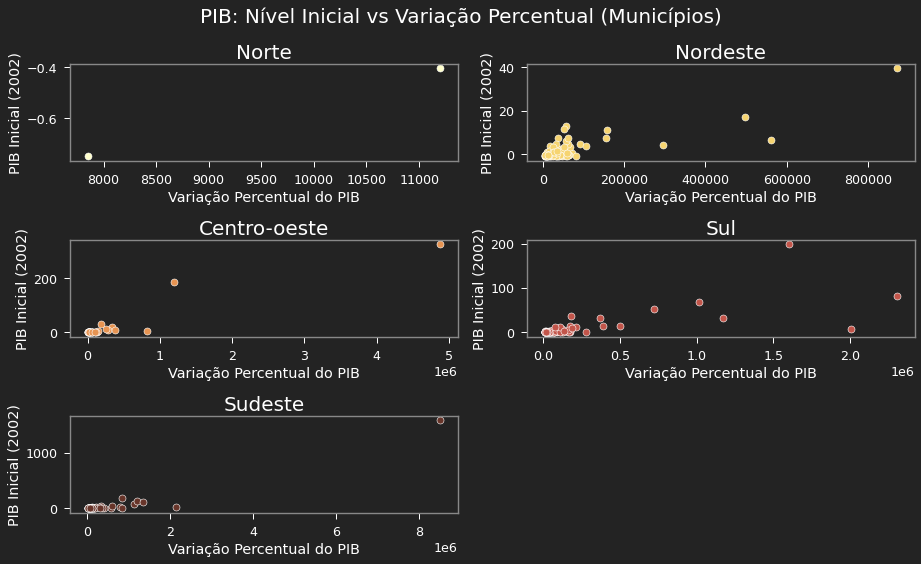

In [34]:
cmap = palettable.scientific.sequential.LaJolla_6.hex_colors[:-1]
for k,v in {0:'Norte',1:'Nordeste',2:'Centro-oeste',3:'Sul',4:'Sudeste'}.items():
    plt.subplot(3,2,k+1)
    sns.scatterplot(data=pib_cities[pib_cities['Região']==v],y='PC_PIB',x=pib_cities[pib_cities['Ano']==2002]['PIB'],
                    color=cmap[k])
    plt.ylabel('PIB Inicial (2002)')
    plt.xlabel('Variação Percentual do PIB')
    plt.title(v)
plt.suptitle('PIB: Nível Inicial vs Variação Percentual (Municípios)', color='w', fontsize=20)
plt.tight_layout();

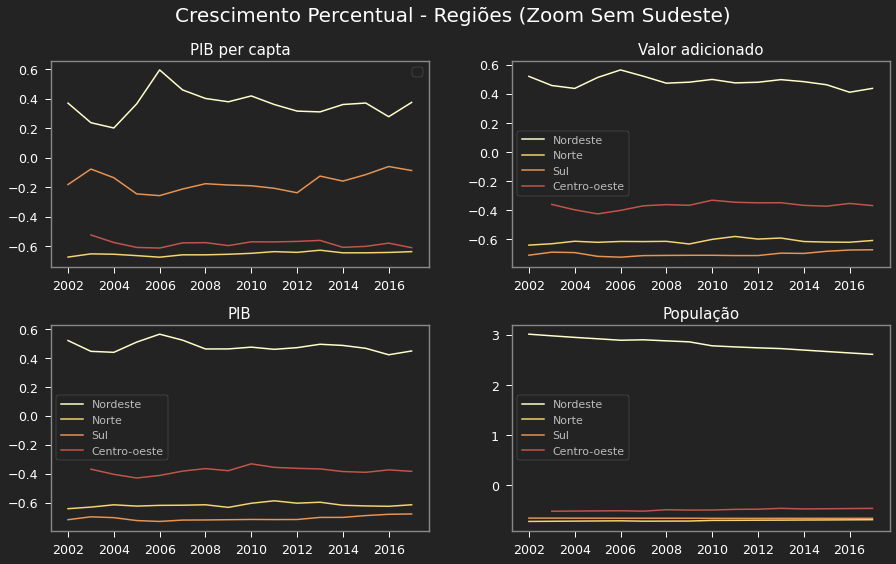

In [77]:
cmap = palettable.scientific.sequential.LaJolla_6.hex_colors[:-2]
agg=pib_cities.groupby(['Ano','Região']).sum()[['PIB per capta','Valor adicionado','PIB','População']].reset_index()
data=agg[['PIB per capta','Valor adicionado','PIB','População']].pct_change().dropna()
data.insert(0,'Ano',agg['Ano'])
data.insert(1,'Região',agg['Região'])
data = data[data['Região']!='Sudeste']
k=1
for i in ['PIB per capta','Valor adicionado','PIB','População']:
    plt.subplot(2,2,k)
    sns.lineplot(data=data,x='Ano',y=i,hue='Região',palette=cmap)
    plt.title(i,size=15)
    plt.xlabel('')
    plt.ylabel('')
    if k==1:
        plt.legend('')
    else:
        plt.legend(fontsize='small',loc='center left')
    k+=1
plt.suptitle("Crescimento Percentual - Regiões (Zoom Sem Sudeste)", color='w', fontsize=20)
plt.tight_layout();

## 4. Análise por Cidade:
A variação proporcional (e não absoluta) permite comparar o crescimento de cidades com economias de tamanhos distintos

In [19]:
def table_plot(restricao,show_table,show_plot):
    "Funcao auxiliar das demais funcoes abaixo. Faz ajustes na tabela e plota o grafico da cidade pedida"
    "Argumentos: restrição gerada pelas outras funções"
    city=restricao[['PIB per capta','Valor adicionado','PIB','População']].pct_change().dropna()
    city.insert(0,'Ano',restricao['Ano'])
    city.insert(1,'Região',restricao['Região'])
    city.insert(2,'UF',restricao['UF'])
    city.insert(3,'Município',restricao['Município'])
    city.insert(4,'Código do Município',restricao['Código do Município'])
    if show_plot==True:
        sns.lineplot(data=city,x='Ano',y='PIB per capta',label='PIB per capta')
        sns.lineplot(data=city,x='Ano',y='Valor adicionado',label='Valor adicionado')
        sns.lineplot(data=city,x='Ano',y='PIB',label='PIB')
        sns.lineplot(data=city,x='Ano',y='População',label='População')
        plt.title(restricao['Município'].values[0]+' - Crescimento Percentual do PIB')
    if show_table == True:
        return city

def pct_change_city_name(regiao,uf,municipio,show_table=False,show_plot=True):
    "Retorna os ganhos percentuais de PIB per capta, Valor Adicionado e PIB para a cidade selecionada"
    "Argumentos: macrorregiao (eg. Nordeste), unidade da federação (eg. Piauí) e municipio (eg. Teresina)"
    restricao = pib_cities[(pib_cities['Região']==regiao)&(pib_cities['UF']==uf)&(pib_cities['Município']==municipio)]
    return table_plot(restricao,show_table,show_plot)

def pct_change_city_code(codigo_do_municipio,show_table=False,show_plot=True):
    "Retorna os ganhos percentuais de PIB per capta, Valor Adicionado e PIB para a cidade selecionada"
    "Argumentos: codigo da cidade do IBGE (eg. 3303302)"
    restricao = pib_cities[pib_cities['Código do Município']==codigo_do_municipio]
    return table_plot(restricao,show_table,show_plot)

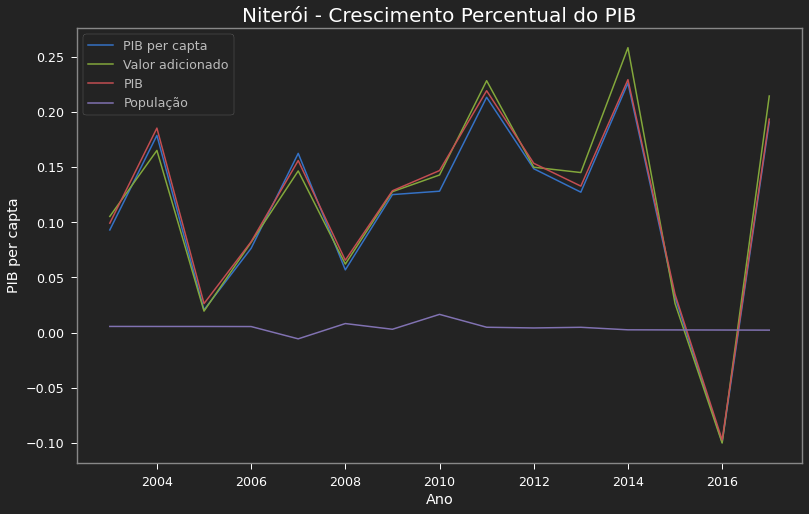

In [22]:
pct_change_city_name('Sudeste', 'Rio de Janeiro', 'Niterói')

In [9]:
pct_change_city_code(3505005,show_table=True,show_plot=False)

,Ano,Região,UF,Município,Código do Município,PIB per capta,Valor adicionado,PIB,População
8227,2003,Sudeste,São Paulo,Barão de Antonina,3505005,0.149206,0.142549,0.137827,-0.009901
8228,2004,Sudeste,São Paulo,Barão de Antonina,3505005,0.045921,0.031456,0.035850,-0.009629
8229,2005,Sudeste,São Paulo,Barão de Antonina,3505005,-0.087769,-0.085737,-0.096981,-0.010098
8230,2006,Sudeste,São Paulo,Barão de Antonina,3505005,0.261338,0.238518,0.248949,-0.009822
8231,2007,Sudeste,São Paulo,Barão de Antonina,3505005,-0.093778,-0.044912,-0.048830,0.049600
8232,2008,Sudeste,São Paulo,Barão de Antonina,3505005,0.115945,0.143015,0.149208,0.029807
8233,2009,Sudeste,São Paulo,Barão de Antonina,3505005,0.019880,0.031184,0.020601,0.000707
8234,2010,Sudeste,São Paulo,Barão de Antonina,3505005,0.052578,0.178693,0.156907,0.099118
8235,2011,Sudeste,São Paulo,Barão de Antonina,3505005,0.153018,0.157091,0.162268,0.008022
8236,2012,Sudeste,São Paulo,Barão de Antonina,3505005,0.121130,0.119248,0.129697,0.007642
